In [3]:
import torch
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete, Tuple
import numpy as np
import random
import os
import gym
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

In [4]:
# # fix something here maybe in order to have it so that action is adjusted in step function to closest action that is allowed at 7am,
# # and so that the action does not result in negative battery level

# def get_legal_actions_at_last(all_actions, current_level, min_level=2):
#     '''
#     Expected behavior: [-2,-1,0,1,2], currently 0 -> [2]
#     Expected behavior: [-2,-1,0,1,2], currently 1 -> [1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 2 -> [0,1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 3 -> [-1,0,1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 4 -> [-2,-1,0,1,2]
#     '''
#     all_actions = np.asarray(all_actions)
#     charge_needed = min_level - current_level
#     avail_actions = all_actions[np.where(all_actions >= charge_needed)]
#     # avail_actions = all_actions[list(np.where(all_actions >= charge_needed)[0])]
#     return avail_actions.tolist()

# def get_legal_actions(all_actions, current_level, min_level=0):
#     all_actions = np.asarray(all_actions)sim
#     underlying_levels = all_actions + current_level
#     # avail_actions = all_actions[list(np.where(underlying_levels >= 0)[0])]
#     avail_actions = all_actions[np.where(underlying_levels >= min_level)]
#     return avail_actions.tolist()


In [5]:
# fix something here maybe in order to have it so that action is adjusted in step function to closest action that is allowed at 7am,
# and so that the action does not result in negative battery level

# def get_legal_actions_at_last(all_actions, current_level, min_level=2):
#     '''
#     Expected behavior: [-2,-1,0,1,2], currently 0 -> [2]
#     Expected behavior: [-2,-1,0,1,2], currently 1 -> [1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 2 -> [0,1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 3 -> [-1,0,1,2]
#     Expected behavior: [-2,-1,0,1,2], currently 4 -> [-2,-1,0,1,2]
#     '''
#     all_actions = np.asarray(all_actions)
#     charge_needed = min_level - current_level
#     avail_actions = all_actions[np.where(all_actions >= charge_needed)]
#     # avail_actions = all_actions[list(np.where(all_actions >= charge_needed)[0])]
#     return avail_actions.tolist()

# def get_legal_actions(all_actions, current_level, min_level=0):
#     all_actions = np.asarray(all_actions)
#     underlying_levels = all_actions + current_level
#     # avail_actions = all_actions[list(np.where(underlying_levels >= 0)[0])]
#     avail_actions = all_actions[np.where(underlying_levels >= min_level)]
#     return avail_actions.tolist()


# def get_legal_range(full_range, current_level, min_level=20):
#     '''
#     Expected behavior: [-25,25], currently 0 -> [20,25]
#     Expected behavior: [-25,25], currently 10 -> [10,25]
#     Expected behavior: [-25,25], currently 20-> [0,25]
#     Expected behavior: [-25,25], currently 30-> [-10,25]
#     Expected behavior: [-25,25], currently 40 -> [-20,25]
#     Expected behavior: [-25,25], currently 50 -> [-25,25]
#     '''
#     full_range = np.asarray(full_range)
#     charge_needed = min_level - current_level
#     avail_actions = [charge_needed, 25]
#     return avail_actions

In [6]:
# # 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# # 2 take at_home out of the state *
# # 3 include the action mechanics inside of the step function *
# # 4 test environment again on random policy loop *
# # 5 try q learning
# # 6 change action to -1, 1 range
# # 7 change reward calculation *
# # 8 test with the test environment (validate using main.py)
# # 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# # 10 change hour from 08-07 to 01-00

# #
# # action comes in in continuous form, is modified in the step function in continuous form within range [-1,1], which
# # is used then to update state variables, i.e. battery level, into a continuous variable between [0,50]
# # state is returned in continuous form
# # in tabular Q learning, state (from env.step) is taken and discretized to get next action
# # in approximator methods, state is taken as continuous and used to get next action

# class StorageEnv(Env):
#     def __init__(self, path_to_train_data):
#         '''
#         Initialization of the energy storage environment;
#         We interpret a run through all historical price data as one trajectory = one episode,
#         where for each hour of each day, we can run the step function to update from one state
#         to the next, given some action for that hour (the step function will return the next
#         state, as well as next reward, and whether the entire historical dataset has been
#         iterated through using the 'done' variable in the return statement).
#         '''

#         self.train_data = pd.read_excel(path_to_train_data)
#         self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
#         self.timestamps = self.train_data['PRICES']
#         self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx


#         self.values_actions =  [-20, -10, 0, 10, 20]
#         self.batteries =  [0, 10, 20, 30, 40, 50]
#         self.action_repr = [-2,-1,0,1,2]

#         self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument

#         self.action_space = Discrete(5, start=-2)
#         self.battery_space = Discrete(6, start=0)
#         self.position_space = Discrete(2, start=0)

#         self.counter = 0
#         self.hour = 1
#         self.day = 1
#         self.num_hours_day = 24

#         self.min_battery_level_start = 20
#         self.min_battery_level = 0
#         self.max_battery_level = 50
#         self.max_charging_level = 25

#         # battery level from 0 to 50 (10 incr.), indication car at home or not
#         self.observation_space = MultiDiscrete([self.battery_space.n,
#                                                 self.position_space.n,
#                                                 self.num_hours_day])

#         # initialize state vars
#         self.battery_level = np.random.randint(self.min_battery_level_start, self.max_battery_level)
#         # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
#         self.at_home = np.random.randint(self.position_space.n) # dont need this anymore or?
#         # initial state
#         self.state = [self.battery_level, self.hour]


#     def step(self, action):
#         ######### at current timestep t
#         ### battery comsumption at timestep t

#         # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
#         if not self.at_home: # check if car is currently away, enforced by overriding previous if statement
#           action = 0

#         # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
#         elif self.at_home:
#           # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
#           if self.hour == 7:
#             legal_actions = get_legal_actions_at_last(self.action_repr, self.battery_level)
#             if action not in legal_actions: # check if action chosen by agent ensures 20kwh of battery at 7am
#               action = min(legal_actions)
#           # rest of the day, ensure that battery stays above 0kwh
#           else:
#             legal_actions = get_legal_actions(self.action_repr, self.battery_level)
#             if action not in legal_actions:
#               action = min(legal_actions)

#         # removing 20kwh from battery when going away from home
#         if not self.at_home:
#           self.battery_level = self.battery_level-2 if self.hour == 0 else self.battery_level

#         # update battery level based on the picked acion at timestep t
#         if self.at_home:
#             self.battery_level += action

#         # no over-charging above 50kwh
#         if self.battery_level >= 5:
#             self.battery_level = 5

#         # should we move the constraints not lower 0 here ??

#         ######### update the state for next hour, timestep t+1
#         # keep the hour 8 ~ 18 same, otherwise athome = True
#         self.at_home = self.at_home if self.hour < 18 else 1

#         # reward calculations
#         # if self.day-1 == 1095:
#         #   print(f"self.day-1 {self.day-1} | self.hour-1 {self.hour-1}  | self.price_values[self.day-1][self.hour-1] {self.price_values[self.day-1][self.hour-1]}  ")
#         hourly_price = self.price_values[self.day-1][self.hour-1]
#         cost_factor = 1.0 if action < 0 else 2.0
#         efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

#         # get amount of kwh bought during this step
#         kwhs_charged = action * 10 # change this 10 when changing action space!!!
#         price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
#         # add reward here, based on price from table

#         reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

#         # update counter and time variables
#         self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
#         self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

#         if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
#             self.hour = 1 # reset hour of the day for next timestep
#             self.day += 1 # increment to start of next day

#         # update state
#         self.state = [self.battery_level, self.hour]

#         # check if all hours in the dataset have been seen
#         self.done = self.counter+1 == self.nr_hours

#         truncated = False
#         info = {}

#         return self.state, reward, self.done, truncated, info

#     def render(self):
#         pass

#     def reset(self):
#       # initialize battery level randomly between 0 and 6, representing the space 0-50kwh
#       self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level)
#       # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
#       self.at_home = np.random.randint(self.position_space.n)
#       # hour may not need to be in the state..?
#       self.hour = 1
#       self.day = 1
#       self.counter = 0
#       self.done = False
#        # initial state
#       self.state = [self.battery_level, self.hour]

#       return self.state

In [7]:
# 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# 2 take at_home out of the state *
# 3 include the action mechanics inside of the step function *
# 4 test environment again on random policy loop *
# 5 try q learning
# 6 change action to -1, 1 range *
# 7 change reward calculation *
# 8 test with the test environment (validate using main.py)
# 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# 10 change hour from 08-07 to 01-00 *

### contuinuous action mechanism:
# action comes in in continuous form in training loop, is modified in the step function in continuous form within range [-1,1], which
# is used then to update state variables, i.e. battery level, into a continuous variable between [0,50]
# state is returned in continuous form
# in tabular Q learning, state (from env.step) is taken and discretized to get next action
# in approximator methods, state is taken as continuous and used to get next action

class StorageEnv(gym.Env):
    def __init__(self, path_to_train_data, num_actions=3, penalty_on=True):
        '''
        Initialization of the energy storage environment;
        We interpret a run through all historical price data as one trajectory = one episode,
        where for each hour of each day, we can run the step function to update from one state
        to the next, given some action for that hour (the step function will return the next
        state, as well as next reward, and whether the entire historical dataset has been
        iterated through using the 'done' variable in the return statement).
        '''

        # check if penalties are enabled or not
        self.penalty_on = penalty_on

        self.train_data = pd.read_excel(path_to_train_data)
        self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.train_data['PRICES']
        self.state = np.empty(3)
        # self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx
        self.nr_hours = np.size(self.price_values)
        # print(self.nr_hours)

        self.battery_range = Box(low=0, high=50, shape=(1,), dtype=np.float32)
        # print(self.price_values.max())
        self.price_range = Box(low=0, high=self.price_values.max(), shape=(1,), dtype=np.float32)
        # self.hour_range = Discrete(24, start=1)

        # obv space: battery level from 0 to 50 (continuous), hour of the dayt
        # self.observation_space = Tuple((self.battery_range, self.hour_range))
        self.position_range = Discrete(2)
        # self.dow_range = Discrete(7)
        # self.month_range = Discrete(12, start=1)
        # obv space: battery level from 0 to 50 (continuous), hour of the dayt
        # self.observation_space = Tuple((self.battery_range, self.price_range, self.hour_range ))

        # self.action_space = np.array([i for i in range(21)]) / 10.0 - 1.0
        self.action_spaces = {
            '3': np.array([-1, 0, 1]),
            '5': np.array([-1, -0.5, 0, 0.5, 1]),
            '11': np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0 ]),
            '21': np.array([-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0 , 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1.0 ])
        }
        self.action_space = self.action_spaces[str(int(num_actions))]

        # print(self.action_space)
        # self.actions = Discrete(len(self.action_repr))
        self.action_space_n = len(self.action_space)
        print(f"Action space ({self.action_space_n} actions): {self.action_space}")
        # self.action_space = Discrete(21, start=-2) # -1 -0.9 8 7 6 5 4 3 2 1 0 1 2 
        # self.cont_action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # self.action_repr = [-2,-1,0,1,2]

        # self.position_space = Discrete(2, start=0)

        # self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
        
        # self.min_battery_level_start = 20  #minimum_morning_level
        # self.min_battery_level = 0
        # self.max_battery_level = 50   #battery_capacity
        # self.max_charging_level = 25
        
        # Battery characteristics
        self.battery_capacity = 50  # kWh
        self.max_power = 25 / 0.9  # kW
        self.charge_efficiency = 0.9  # -
        self.discharge_efficiency = 0.9  # -
        # self.battery_level = self.battery_capacity / 2  # kWh (start at 50%)
        self.minimum_morning_level = 20  # kWh
        self.car_use_consumption = 20  # kWh

        # Time Tracking
        # self.counter = 0
        # self.hour = 1
        # self.day = 1
        # self.car_is_available = True

        # initialize state vars
        # self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level) # continuous value between 20 and 50
        # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
        # self.at_home = np.random.randint(self.position_space.n) # 50% chance at home at start of each day
        # initial state
        # self.state = np.array([self.battery_level, self.hour])


    def step(self, action): # action is between -1 and 1
        action = np.squeeze(action)
        # print(action)
        ######### at current timestep t
        ### battery comsumption at timestep t
        
        if action <-1 or action >1:
            raise ValueError('Action must be between -1 and 1')
        
        # store the action into action_bs
        action_bs = action
        # Calculate if, at 7am and after the chosen action, the battery level will be below the minimum morning level:
        penalty = 0.0 # peality
        if self.hour == 7:
            if action > 0 and (self.battery_level < self.minimum_morning_level):
                if (
                        self.battery_level + action * self.max_power * self.charge_efficiency) < self.minimum_morning_level:  # If the chosen action will not charge the battery to 20kWh
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)  # Charge until 20kWh
                    # charge higher to nearest legal action
                    # action = math.ceil(action * 10.0) / 10.0

            elif action < 0:
                if (self.battery_level + action * self.max_power) < self.minimum_morning_level:
                    if self.battery_level < self.minimum_morning_level:  # If the level was lower than 20kWh, charge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                                    self.max_power * self.charge_efficiency)  # Charge until 20kWh
                        # charge higher to nearest legal action
                        # action = math.ceil(action * 10.0) / 10.0
                    elif self.battery_level >= self.minimum_morning_level:  # If the level was higher than 20kWh, discharge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                            self.max_power)  # Discharge until 20kWh
                        # discharge less to keep higher than 20kwh
                        # action = math.ceil(action * 10.0) / 10.0
            elif action == 0:
                if self.battery_level < self.minimum_morning_level:
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)
                    # charge higher to nearest legal action
                    # action = math.ceil(action * 10.0) / 10.0
                    
        if abs(action_bs - action) != 0:   
            #* np.exp(abs(action_bs - action))
            penalty += 1000.0 if self.penalty_on else 0.

        # if it is 8am, decide whether car will go away or stay (by random chance)
        if self.hour == 8:
            # self.car_is_available = np.random.choice([True, False])
            if not self.car_is_available:
                self.battery_level -= self.car_use_consumption
                
        # if self.hour == 18:
        #     self.car_is_available = True
            
        # convert action [-1,1] to actual kwh charging (transform to [-25,25])
        # if action > 0:
        #   action = action * self.max_power * self.charge_efficiency
        # # action = action * self.max_charging_level # now action lies in [-25,25]
        # else:
        #   action = action * self.max_power

        # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
        if not self.car_is_available: # check if car is currently away, enforced by overriding previous if statement
            action = 0
            if abs(action_bs - action) != 0:   
                #* np.exp(abs(action_bs - action))
                penalty += 1000.0 if self.penalty_on else 0.


        # Calculate the costs and battery level when charging (action >0)
        if (action > 0) and (self.battery_level <= self.battery_capacity):
            if (self.battery_level + action * self.max_power * self.charge_efficiency) > self.battery_capacity:
                action = (self.battery_capacity - self.battery_level) / (self.max_power * self.charge_efficiency)
                # charge less to nearest legal action
                # action = math.floor(action * 10.0) / 10.0
            charged_electricity_kW = action * self.max_power
            charged_electricity_costs = charged_electricity_kW * self.price_values[self.day - 1][
                self.hour - 1] * 2 * 1e-3
            if abs(action_bs - action) != 0:
                penalty += 1000.0 if self.penalty_on else 0.
            reward = -charged_electricity_costs - penalty
            self.battery_level += charged_electricity_kW * self.charge_efficiency

        # Calculate the profits and battery level when discharging (action <0)
        elif (action < 0) and (self.battery_level >= 0):
            if (self.battery_level + action * self.max_power) < 0:
                action = -self.battery_level / (self.max_power)
                # discharge less to nearest legal action
                # action = math.ceil(action * 10.0) / 10.0
            if abs(action_bs - action) != 0:
                penalty += 1000.0 if self.penalty_on else 0
                
            discharged_electricity_kWh = action * self.max_power  # Negative discharge value
            discharged_electricity_profits = abs(discharged_electricity_kWh) * self.discharge_efficiency * \
                                             self.price_values[self.day - 1][self.hour - 1] * 1e-3
                                             
            reward = discharged_electricity_profits - penalty
            self.battery_level += discharged_electricity_kWh
            # Some small numerical errors causing the battery level to be 1e-14 to 1e-17 under 0 :
            if self.battery_level < 0:
                self.battery_level = 0

        else:
            reward = 0.
            

        # # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
        # if self.car_is_available:
        #   low = self.cont_action_space.low[0]
        #   high = self.cont_action_space.high[0]
        #   # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
        #   if self.hour == 7: # adapt legal action calculating functions
        #     legal_actions = get_legal_range([low, high], self.battery_level, min_level = 20)
        #     if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures 20kwh of battery at 7am
        #       action = legal_actions[0] # charge needed for 20kwh, if initial action would result in <20 charge
        #   # rest of the day, ensure that battery stays above or at 0kwh
        #   else:
        #     legal_actions = get_legal_range([self.cont_action_space.low[0], self.cont_action_space.high[0]], self.battery_level, min_level=0)
        #     if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures >=0kwh of battery at 7am
        #       action = legal_actions[0] # charge needed to have positive >=0kwh charge, if initial action would result in negative <0kwh

        # removing 20kwh from battery when going away from home
        # if not self.car_is_available:
        #   self.battery_level = self.battery_level - 20 if self.hour == 8 else self.battery_level

        # update battery level based on the picked acion at timestep t
        # if self.car_is_available:
        #     self.battery_level += action

        # no over-charging above 50kwh
        # if self.battery_level >= 50:
        #     self.battery_level = 50

        # should we move the constraints not lower 0 here ??

        ######### update the state for next hour, timestep t+1
        # keep the hour 8 ~ 18 same, otherwise athome = True
        # self.car_is_available = self.car_is_available if 8 <= self.hour < 18 else 1 # TO-DO: check if this should not be <= 18 instead

        # reward calculations
        # hourly_price = self.price_values[self.day-1][self.hour-1]
        # cost_factor = 1.0 if action < 0 else 2.0
        # efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

        # get amount of kwh bought during this step
        # kwhs_charged = action # just for reading clarity
        # price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
        # # reward, based on current price from table
        # reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

        # update counter and time variables
        self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
        self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

        if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
            self.hour = 1 # reset hour of the day for next timestep
            self.day += 1 # increment to start of next day
             
        if self.hour == 8:
            self.car_is_available = np.random.choice([True, False])
    
        if self.hour == 18:
            self.car_is_available = True

        # update state
        self.state = self.observation()


        # check if all hours in the dataset have been seen
        # self.done = self.counter == self.nr_hours - 1
        terminated = self.counter == self.nr_hours - 1
        truncated = False
        
        info = action

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass
      
    def observation(self):  # Returns the current state
        battery_level = self.battery_level
        price = self.price_values[self.day - 1][self.hour - 1]
        # print(price.max(), price.min())
        hour = self.hour
        day_of_week = self.timestamps[self.day - 1].dayofweek  # Monday = 0, Sunday = 6
        day_of_year = self.timestamps[self.day - 1].dayofyear  # January 1st = 1, December 31st = 365
        month = self.timestamps[self.day - 1].month  # January = 1, December = 12
        year = self.timestamps[self.day - 1].year
        self.state = np.array([
              battery_level, 
              price, 
              int(hour), 
            #   int(self.car_is_available),
            #   int(day_of_week), 
              #int(day_of_year), 
            #   int(month), 
              #int(year),
             ])
        # if match  
        # print(self.state)
        # print(f"{self.timestamps[self.day - 1]} --   {day_of_week}")
        return self.state

    def reset(self):
      self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
      self.counter = 0
      self.hour = 1
      self.day = 1
      # self.car_is_available = True
      # self.at_home = self.car_is_available  

        # resetting battery charge state var, random re-initialization between 0 and 50kwh
        #   if self.hour == 8:
        #     self.battery_level = np.random.uniform(self.minimum_morning_level, self.battery_capacity) # continuous value between 20 and 50
        #   elif 8 < self.hour <= 18:
        #     self.battery_level = np.random.uniform(0, self.battery_capacity-self.minimum_morning_level) # continuous value between 20 and 50
        #   else:
      self.battery_level = np.random.uniform(0, self.battery_capacity) # continuous value between 0 and 50
        
      # randomly re-initialize athome with 50/50 chance of being away at hour 0 (8am) or not

      self.car_is_available = True  # np.random.randint(self.position_space.n) # 50% chance at home at start of each day
      # new initial state
      self.state = self.observation()
    #   self.state = np.array([self.battery_level, self.hour])

      return self.state

In [18]:
class QAgent():
    
    def __init__(self, env, bin_size = {'battery': 6, 'price': 3,'hour': 3, 'action': 3},
                  properties = {'reward_shaping':True, 'penalties':True, 'nr_simulations':10, 'discount_rate':0.95}):
        
        '''
        Params:
        
        env_name = name of the specific environment that the agent wants to solve
        discount_rate = discount rate used for future rewards
        bin_size = number of bins used for discretizing the state space
        
        '''
        
        #create an environment
        self.env = env
        
        # get all agent properties
        self.properties = properties
        self.discount_rate = self.properties['discount_rate']
        self.properties_path = f"disc_{self.properties['discount_rate']}_shap_{self.properties['reward_shaping']}_pen_{self.properties['penalties']}_sims_{self.properties['nr_simulations']}"

        # get all the bin sizes
        self.bin_size = bin_size
        
        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        # self.action_space = self.env.action_space.n
        

        # self.action_repr = self.env.action_space
        # self.actions = Discrete(len(self.action_repr))
        self.action_space = self.env.action_space_n
        values_price = self.env.price_values.flatten()
        self.bin_prices = {
            '3': np.quantile(values_price, [0, 0.5, 0.99]),
            '4': np.quantile(values_price, [0, 0.33, 0.66, 0.99]),
            '5': np.quantile(values_price, [0, 0.25, 0.5, 0.75, 0.99]),
            '7': np.quantile(values_price, [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.99]),
            '11': np.quantile(values_price, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]),   
        }

        # self.bin_hours = {
        #     '3': np.quantile(values_price, [0, 0.5, 1]),
        #     '5': np.quantile(values_price, [0, 0.25, 0.5, 0.75, 1]),
        #     '7': np.quantile(values_price, [0, 0.2, 0.4, 0.6, 0.7, 0.8, 1]),
        #     '11': np.quantile(values_price, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),   
        # }
        
        # print(self.action_space, self.bin_size)
        
        #State incorporates the observation state
        #State[0] is x position
        #State[1] is velocity
    
        #Get the low and high values of the environment space
        # self.low = self.env.observation_space.low
        # self.high = self.env.observation_space.high
        
        
        self.battery_low = self.env.battery_range.low[0]
        self.battery_high = self.env.battery_range.high[0]
        self.hour_low = 0
        self.hour_high = 24
        
        #Create bins for both observation features
        self.bin_battery = np.linspace(self.battery_low, self.battery_high, self.bin_size['battery'])
        print(f"Battery Levels ({self.bin_size['battery']} bins): {self.bin_battery}")
        # 0.01
        # confidence interval 99%
        # print(np.quantile(values_price, 0.99))
        # print(str(self.bin_size['price']))
        # print(self.bin_prices[str(self.bin_size['price'])])
        # self.bin_price = np.linspace(0, np.quantile(values_price, 0.99), self.bin_prices[str(self.bin_size['price'])])
        # self.bin_price = np.concatenate((np.array([0]), self.bin_prices[str(self.bin_size['price'])][1:]))
        self.bin_price = self.bin_prices[str(self.bin_size['price'])]
        print(f"Prices ({str(self.bin_size['price'])} bins): {self.bin_price}")
        
        self.bin_hour = np.linspace(self.hour_low, self.hour_high, self.bin_size['hour'] + 1)
        print(f"Hours ({self.bin_size['hour']} bins): {self.bin_hour}")
        '''
        ToDo:
        
        Please create the bins for the velocity feature in the same manner and call this variable self.bin_velocity!
        '''
        
        #Solution
        # self.bin_hour = np.linspace(self.hour_low, self.hour_high, self.bin_size['hour']) 
        
        #Append the two bins
        self.bins = [self.bin_battery, self.bin_price, self.bin_hour]
        
        self.total_output = {}
        
    
    def get_shaping_reward(self, state, next_state):
        battery_level, electricity_price, hour = state[0], state[1], state[2]
        next_battery_level, next_electricity_price, next_hour = next_state[0], next_state[1], next_state[2]

        extra_reward = 0.0
        weight = 100.0   
         
        if next_battery_level < battery_level: # sell
            extra_reward = (electricity_price - 2 * next_electricity_price) * (battery_level - next_battery_level)
        if next_battery_level > battery_level: # buy
            extra_reward = (2 * electricity_price - next_electricity_price) * (battery_level - next_battery_level)
        
        return weight * extra_reward
    
    def discretize_state(self, state):
        
        '''
        Params:
        state = state observation that needs to be discretized
        
        
        Returns:
        discretized state
        '''
        #Now we can make use of the function np.digitize and bin it
        self.state = state
        # print(f"self.state: {self.state}")
        
        #Create an empty state
        digitized_state = []
    
        # (-inf, 0) [0, 1)    [50, )  # 52 states
        digitized_state.append(np.digitize(self.state[0], self.bins[0], right=False) -1) 
        digitized_state.append(np.digitize(self.state[1], self.bins[1], right=False) -1)
        digitized_state.append(np.digitize(self.state[2], self.bins[2], right=True) -1)
        

        #Returns the discretized state from an observation
        return digitized_state
    
    
    def create_Q_table(self):
        # self.state_space = self.bin_size - 1
        #Initialize all values in the Q-table to zero
        self.state_battery_space = self.bin_size['battery']
        self.state_hour_space = self.bin_size['hour']
        self.state_price_space = self.bin_size['price']

        '''
        ToDo:
        Initialize a zero matrix of dimension state_space * state_space * action_space and call it self.Qtable!
        '''
        
        #Solution:
        # self.Qtable = np.zeros((self.state_space, self.state_space, self.action_space))
        self.Qtable = np.zeros((self.state_battery_space, 
                                self.state_price_space,
                                self.state_hour_space,
                                self.action_space))
        # print(self.Qtable.shape)
        
    def save_Q_table(self):
        table_shape = self.Qtable.shape
        
        num_battery_levels = table_shape[0]
        num_price_levels = table_shape[1]
        num_hours = table_shape[2]
        num_actions = table_shape[3]
        
        filename = f"qtable_{self.properties_path}_batt_{num_battery_levels}_price_{num_price_levels}_hour_{num_hours}_action_{num_actions}.npy"
        self.k = filename
        np.save(f"../../../data/{filename}", self.Qtable)
        print(f"{filename} is saved ...")
        
    def load_Q_table(self):
        filename = f"qtable_{self.properties_path}_batt_{self.bin_size['battery']}_price_{self.bin_size['price']}_hour_{self.bin_size['hour']}_action_{self.bin_size['action']}.npy"
        qtable = np.load(f"../../../data/{filename}")
        return qtable

    def train(self, learning_rate, epsilon = 0.05, epsilon_decay = 200, adaptive_epsilon = False, 
              adapting_learning_rate = False):
        
        '''
        Params:
        
        simulations = number of episodes of a game to run
        learning_rate = learning rate for the update equation
        epsilon = epsilon value for epsilon-greedy algorithm
        epsilon_decay = number of full episodes (games) over which the epsilon value will decay to its final value
        adaptive_epsilon = boolean that indicates if the epsilon rate will decay over time or not
        adapting_learning_rate = boolean that indicates if the learning rate should be adaptive or not
        
        '''
        
        #Initialize variables that keep track of the rewards
        self.rewards = []
        self.average_rewards = []
        self.num_simulations = []
        
        #Call the Q table function to create an initialized Q table
        self.create_Q_table()
        
        #Set epsilon rate, epsilon decay and learning rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        #Set start epsilon, so here we want a starting exploration rate of 1
        self.epsilon_start = 1
        self.epsilon_end = 0.05
        
        #If we choose adaptive learning rate, we start with a value of 1 and decay it over time!
        if adapting_learning_rate:
            self.learning_rate = 1
        
        for i in range(self.properties['nr_simulations']):
            # initialize output for current simulation
            self.total_output[i] = {'rewards': [], 'actions': [], 'battery_levels': []}
            
            if i % 10 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            # print(f'Please wait, the algorithm is learning! The current simulation is {i}')           
            #Initialize the state
            # state = self.env.reset()[0]   # reset returns a dict, need to take the 0th entry.
            state = self.env.reset()
        
            #Set a variable that flags if an episode has terminated
            done = False
        
            #Discretize the state space
            # continous_state = state
            state = self.discretize_state(state)
            
            
            #Set the rewards to 0
            total_rewards = 0
            
            #If adaptive epsilon rate

            # epsilon = 0.05
            # epsilon_decay = 1000
            
            # self.epsilon_start = 1
            # self.epsilon_end = 0.05
            if adaptive_epsilon:
                self.epsilon = np.interp(i, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
                
                #Logging just to check it decays as we want it to do, we just print out the first three statements
                if i % 5 == 0 and i <= 100:
                    print(f"The current epsilon rate is {self.epsilon}")
                
            #Loop until an episode has terminated
            while not done:
                
                #Pick an action based on epsilon greedy
                
                '''
                ToDo: Write the if statement that picks a random action
                Tip: Make use of np.random.uniform() and the self.epsilon to make a decision!
                Tip: You can also make use of the method sample() of the self.env.action_space 
                    to generate a random action!
                '''
                
                #Solution:
                
                #Pick random action
                if np.random.uniform(0, 1) > 1-self.epsilon:
                    #This picks a random action from 0,1,2
                    # action = self.env.action_space.sample()
                    action = np.random.choice(self.env.action_space)
                    action_i = np.where(self.env.action_space == action)[0][0]   
                #Pick a greedy action
                else:
                    action_i = np.argmax(self.Qtable[state[0],
                                                     state[1],
                                                     state[2],
                                                     :])
                    action = self.env.action_space[action_i]

                # Correct small numerical errors :  
                action = round(action, 3)
                    
                #Now sample the next_state, reward, done and info from the environment
                
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done =  terminated or truncated
                

                # continous_next_state = next_state
                next_state = self.discretize_state(next_state)
                # print(next_state)
                #Target value 

                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], 
                                                                           next_state[1],
                                                                           next_state[2],
                                                                           ]))
                
                # enable/disable reward shaping
                if self.properties["reward_shaping"]:
                    Q_target += self.get_shaping_reward(state, next_state)
                
                #Calculate the Temporal difference error (delta)
                delta = self.learning_rate * (Q_target - self.Qtable[state[0], 
                                                                     state[1], 
                                                                     state[2],     
                                                                     action_i])
                
                #Update the Q-value
                self.Qtable[state[0], 
                            state[1], 
                            state[2], 
                            action_i] = self.Qtable[state[0], 
                                                    state[1], 
                                                    state[2], 
                                                    action_i] + delta
                
                # update the reward and the hyperparameters
                # and transform from numpy dtypes to native python types if necessary (to allow JSON encoding) 

                # print('reward', reward, type(reward))
                # print('action', action, type(action))
                # print('battery', state[0], type(state[0]))
                self.total_output[i]['rewards'] += [float(reward)] if not isinstance(reward,float) else [reward]
                self.total_output[i]['actions'] += [float(action)] if not isinstance(action,float) else [action]
                self.total_output[i]['battery_levels'] += [int(state[0])] if not isinstance(state[0],int) else [state[0]]
                
                total_rewards += reward

                # update state to next state
                state = next_state
                
                
            
            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i+1)
            
            self.rewards.append(total_rewards)
            
            #Calculate the average score over 100 episodes
            if i % 10 == 0:
                self.average_rewards.append(np.mean(self.rewards))
                self.num_simulations.append(i+1)
                
                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []
        
        print('The simulation is done!')
        

        
    def visualize_rewards(self):
        plt.figure(figsize =(7.5,7.5))
        plt.plot(self.num_simulations, self.average_rewards)
        # plt.axhline(y = -110, color = 'r', linestyle = '-')
        plt.title('Average reward over the past 10 simulations', fontsize = 10)
        # plt.legend(['Q-learning performance','Benchmark'])
        plt.xlabel('Number of simulations', fontsize = 10)
        plt.ylabel('Average reward', fontsize = 10)
            


In [20]:
#We can also train the Qagent with a decaying epsilon schedule
config_file = open('../../../config.json')
config = json.load(config_file)

bin_size, properties, learning_rate = config['bin_size'], config['properties'], config['learning_rate']

# num_battery_levels can be 6 11 26 51         => not test for now : 26, 51
# num_actions can be 3, 5,                     => not test for now : 11, 21
# num_hours can be 3, 4, 6, 12, 24             => not test for now : 12, 24
# num price can be 3, 4, 5, 7, 11              => not test for now : 11

env = StorageEnv(path_to_train_data="../../../data/train.xlsx", num_actions=bin_size['action'], penalty_on=properties['penalties'])

agent_epsilon_decay = QAgent(env, bin_size=bin_size, properties=properties)
agent_epsilon_decay.train(learning_rate=learning_rate, adaptive_epsilon=True)
agent_epsilon_decay.save_Q_table()

# create file to store all rewards in if it doesnt exist yet
if not os.path.isfile('train_rewards.txt'):
    rewards = {}

else:
    # reading the rewards data from the file 
    with open('train_rewards.txt', 'r') as f:
        data = f.read()
        
    # reconstructing the data as a dictionary 
    rewards = json.loads(data)

# agent_epsilon_decay.num_simulations
# add current run to rewards dictionary
rewards[agent_epsilon_decay.k] = [agent_epsilon_decay.num_simulations, agent_epsilon_decay.average_rewards]# agent_epsilon_decay.total_output

# save new rewards dictionary to file
with open('train_rewards.txt', 'w') as f: 
     f.write(json.dumps(rewards))


# with open(filename, 'w') as f:
#     json.dump(agent_epsilon_decay.total_rewards, f)

Action space (3 actions): [-1  0  1]
Battery Levels (6 bins): [ 0. 10. 20. 30. 40. 50.]
Prices (3 bins): [1.0e-02 4.3e+01 1.5e+02]
Hours (3 bins): [ 0.  8. 16. 24.]
Please wait, the algorithm is learning! The current simulation is 0
The current epsilon rate is 1.0
Please wait, the algorithm is learning! The current simulation is 1
The current epsilon rate is 0.99525
Please wait, the algorithm is learning! The current simulation is 2
The current epsilon rate is 0.9905
Please wait, the algorithm is learning! The current simulation is 3
The current epsilon rate is 0.98575
Please wait, the algorithm is learning! The current simulation is 4
The current epsilon rate is 0.981
Please wait, the algorithm is learning! The current simulation is 5
The current epsilon rate is 0.97625
Please wait, the algorithm is learning! The current simulation is 6
The current epsilon rate is 0.9715
Please wait, the algorithm is learning! The current simulation is 7
The current epsilon rate is 0.96675
Please wait

In [ ]:
# get notebook version from Wenhua
# add reward saving properly with dict, make sure rewards from train and rewards/actions/battery levels from test are being saved
# push main.py to github
# run best config for all experiments
# finish plottig functios
# write report

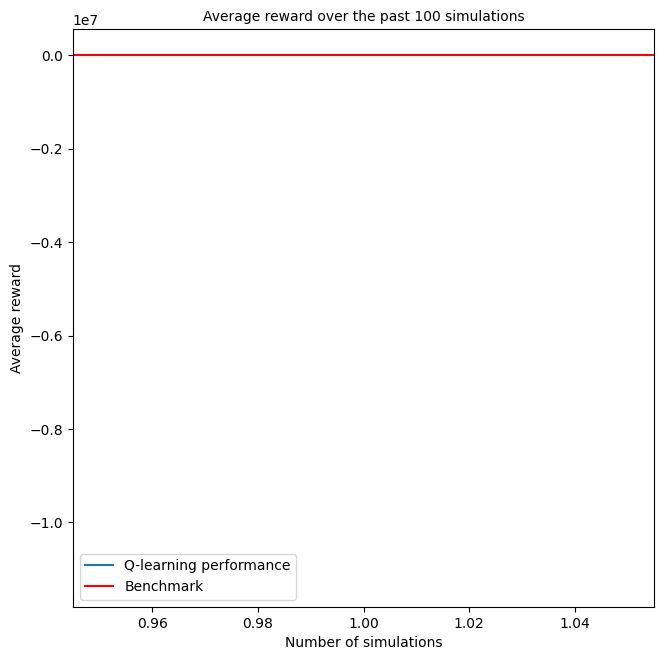

In [ ]:
agent_epsilon_decay.visualize_rewards()